<a href="https://colab.research.google.com/github/YANG-HUAIJIANG/Python-code-for-cell-image/blob/main/FIT3181_5215_ViT_ModelFineTuning_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2024)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Head Tutor 3181:*  **Miss Vy Vo** |  \[tran.vo@monash.edu \] <br/>
*Head Tutor 5215:*  **Dr Van Nguyen** |  \[van.nguyen1@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# Tutorial 10: ViT Transfer learning, Model Fine-Tuning with prompts and Adapters

####Acknowledge
- This tutorial is developped based on [this repo](https://github.com/KMnP/vpt/tree/main).

###I) Introduction of ViT and Model Fine-Tuning

###II) Transfer Learning with a Pre-trained ViT

We first download the pre-trained ViT-B_16 and store on Google Colab drive.

In [ ]:
# Load imagenet21k pre-train weights for ViT-B_16
!wget https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz

--2024-09-27 02:26:23--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: ‘ViT-B_16.npz’

ViT-B_16.npz        100%[===================>] 393.69M  24.8MB/s    in 17s     

2024-09-27 02:26:41 (23.3 MB/s) - ‘ViT-B_16.npz’ saved [412815506/412815506]



In [ ]:
!pip install ml_collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=b12573deadefeb47abb018efbf626f951e4bd56087bb236056f803ec0bf4fca7
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


We import the necessary libraries and packages.

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import copy
import logging
import math
from tqdm import tqdm
import ml_collections

from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
import torchvision
import torchvision.transforms as transforms


We load Flower102 dataset.

In [ ]:
# Load Flowers102 dataset
img_size = 224
num_classes = 102
train_transform = transforms.Compose([
                transforms.Resize(size=(int(img_size / 0.875), int(img_size / 0.875))),
                transforms.RandomCrop(img_size),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ColorJitter(brightness=0.126, saturation=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
test_transform = transforms.Compose([
                transforms.Resize(size=(img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

train_set = torchvision.datasets.Flowers102(root="./dataset", split="train", download=True, transform=train_transform)
val_set = torchvision.datasets.Flowers102(root="./dataset", split="val", download=True, transform=train_transform)
total_train_dataset = torch.utils.data.ConcatDataset([train_set, val_set])
test_dataset = torchvision.datasets.Flowers102(root="./dataset", split="test", download=True, transform=test_transform)
train_loader = torch.utils.data.DataLoader(total_train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

100%|██████████| 344862509/344862509 [00:14<00:00, 24342998.18it/s]


Extracting dataset/flowers-102/102flowers.tgz to dataset/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1123554.22it/s]


100%|██████████| 14989/14989 [00:00<00:00, 16614276.60it/s]


In [ ]:
# # Load Food101 dataset
# img_size = 224
# num_classes = 101 # Number of classes of Food101 dataset
# train_transform = transforms.Compose([
#                 transforms.Resize(size=(int(img_size / 0.875), int(img_size / 0.875))),
#                 transforms.RandomCrop(img_size),
#                 transforms.RandomHorizontalFlip(0.5),
#                 transforms.ColorJitter(brightness=0.126, saturation=0.5),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                 ])
# test_transform = transforms.Compose([
#                 transforms.Resize(size=(img_size, img_size)),
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#             ])

# train_set = torchvision.datasets.Food101(root="./dataset", split="train", download=True, transform=train_transform)
# test_dataset = torchvision.datasets.Food101(root="./dataset", split="test", download=True, transform=test_transform)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

This code snippet outlines a set of default configurations and utility functions for the Vision Transformer (ViT) model. ViT is a Transformer-based model designed for image classification, where images are processed as a sequence of patches instead of individual pixels, leveraging the attention mechanism traditionally used in NLP. The configuration defines key model components such as the multi-head attention query (`ATTENTION_Q`), key (`ATTENTION_K`), value (`ATTENTION_V`), and output (`ATTENTION_OUT`) layers, as well as fully connected layers (`FC_0` and `FC_1`) within the multi-layer perceptron (MLP) block and normalization layers (`ATTENTION_NORM` and `MLP_NORM`).

The utility function `np2th` is used to convert weights from a NumPy format into a PyTorch tensor, with an option to adjust tensor shapes for convolutional layers. Additionally, the code includes an activation function dictionary (`ACT2FN`), which maps activation function names (like `gelu`, `relu`, and `swish`) to their respective implementations in PyTorch. This setup facilitates flexibility in selecting the desired activation functions and ensures smooth conversion of weights for initializing the ViT model in a PyTorch environment.

In [ ]:
# VIT default config
ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}

We create a ViT_B_16 model and then load the weights of the pre-trained ViT_B_16 model to our declared ViT_B_16 architecture.  

We first declare the Self-Attention layer for our ViT. The `Attention` class defines the attention mechanism used in the Vision Transformer (ViT) model. It supports multi-head attention with a configurable number of heads, where each head processes part of the input independently. The class includes layers for query, key, and value projections, along with dropout regularization for both the attention scores and output. The `forward` method computes the scaled dot-product attention by first projecting the input (`hidden_states`) into queries, keys, and values, then calculating attention scores and applying a softmax to obtain attention probabilities. These probabilities are used to weight the value vectors, producing the final context that is transformed back through an output projection. The model supports optional visualization of attention weights.

In [ ]:
class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


This __init__ method initializes the attention mechanism in a Vision Transformer (ViT) model.
- self.vis:
  - vis is a parameter that indicates whether to visualize attention weights during training. This can be useful for interpreting the attention mechanism.
- Attention Head Configuration:
  - self.num_attention_heads: This defines the number of attention heads in the multi-head attention mechanism, retrieved from the model's configuration.
  - self.attention_head_size: This represents the size (or dimensionality) of each attention head. It's calculated by dividing the total hidden size of the model (config.hidden_size) by the number of attention heads.
  - self.all_head_size: This is the total size for all heads combined, which is simply the product of self.num_attention_heads and self.attention_head_size.
- Query, Key, and Value Projections:
  - self.query, self.key, self.value: These are linear layers that project the input (hidden states) into query, key, and value vectors for each attention head. Each layer has an input size of config.hidden_size and an output size of self.all_head_size (which is the size of all attention heads combined).
- Output Projection:
  - self.out: After computing the attention context, this linear layer projects the result back to the original hidden size (config.hidden_size).

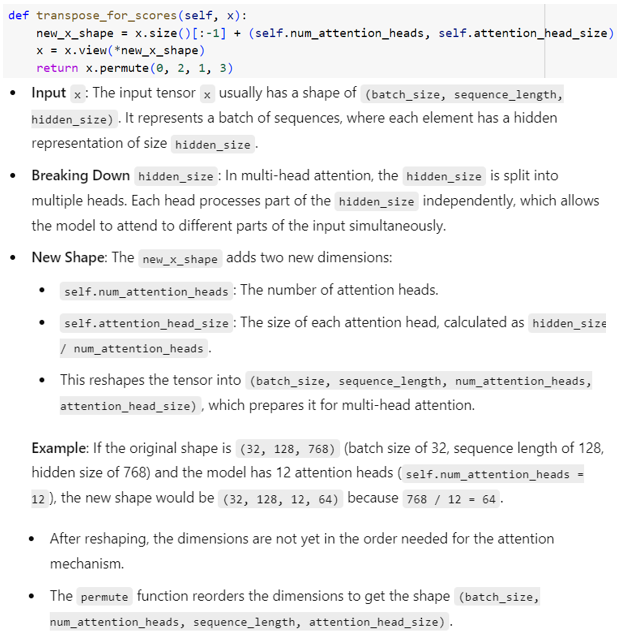

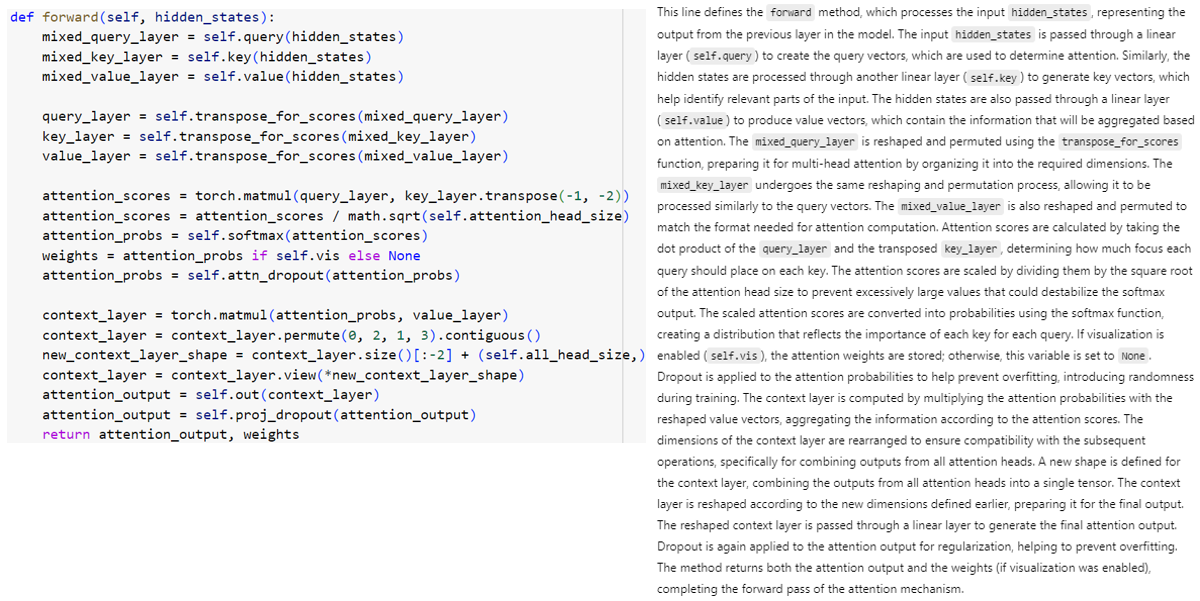

The `Mlp` class defines a multi-layer perceptron (MLP) module for a neural network, inheriting from `nn.Module`. In its constructor, it initializes two linear layers (`fc1` and `fc2`) that transform the input size to a specified hidden size and then back to the original size, respectively. The activation function used is Gaussian Error Linear Unit (GELU), chosen from a predefined set (`ACT2FN`). A dropout layer is included to regularize the model and reduce overfitting, with the dropout rate sourced from the configuration. The `_init_weights` method initializes the weights of the linear layers using Xavier uniform initialization for weights and normal initialization for biases. The `forward` method processes the input `x` by passing it through the first linear layer, applying the activation function, performing dropout, then passing it through the second linear layer followed by another dropout, before returning the final output.

In [ ]:
class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

The `Embeddings` class constructs embeddings from image patches and position embeddings for a vision transformer model. In its constructor, it initializes several parameters, determining the patch size and number of patches based on the provided configuration and image size. If a grid configuration is specified, it calculates the patch size accordingly and sets a flag for hybrid processing, which indicates that a ResNet model will be used to extract features. The class initializes a convolutional layer for patch embeddings, a parameter for position embeddings, and a classification token to prepend to the sequence of embeddings. The `forward` method processes the input image tensor, optionally passing it through the hybrid model if enabled, then applies the convolutional layer to generate patch embeddings. These embeddings are flattened, transposed, and concatenated with the class token. Finally, the position embeddings are added, dropout is applied for regularization, and the final embeddings are returned.

In [ ]:
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        # Initialize the parent nn.Module class
        super(Embeddings, self).__init__()
        # Set the hybrid flag to None initially (used for hybrid model like ResNetV2)
        self.hybrid = None
        # Ensure img_size is a pair of values (height, width)
        img_size = _pair(img_size)
        # If the configuration has a grid for patches, compute the patch size based on grid dimensions
        if config.patches.get("grid") is not None:
          grid_size = config.patches["grid"]
          # Calculate the patch size by dividing image size by 16 and the grid size
          patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
          # Calculate the total number of patches (for position embeddings)
          n_patches = (img_size[0] // 16) * (img_size[1] // 16)
          # Set hybrid to True indicating usage of a hybrid model (e.g., ResNet)
          self.hybrid = True
        else:
          # Otherwise, use the patch size from the config directly
          patch_size = _pair(config.patches["size"])
          # Calculate the number of patches based on image and patch sizes
          n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
          # Set hybrid to False indicating no hybrid model is used
          self.hybrid = False
      # If hybrid is enabled, initialize the ResNetV2 model with given parameters
        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers,
                                 width_factor=config.resnet.width_factor)
          # Update in_channels to match the output channels of the ResNet model
            in_channels = self.hybrid_model.width * 16
      # Create a 2D convolutional layer for patch embeddings, with input channels set by the hybrid model
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                               out_channels=config.hidden_size,
                               kernel_size=patch_size,
                               stride=patch_size)
      # Initialize learnable position embeddings for patches and class token
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, config.hidden_size))
      # Initialize a class token (CLS token) for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))
      # Dropout layer to prevent overfitting, with the rate specified in the config
        self.dropout = Dropout(config.transformer["dropout_rate"])

    def forward(self, x):
        # Get the batch size (B) from the input tensor 'x'
        B = x.shape[0]
        # Expand the class token (cls_token) for each image in the batch
        cls_tokens = self.cls_token.expand(B, -1, -1)
        # If using a hybrid model (e.g., ResNet for feature extraction), pass 'x' through it
        if self.hybrid:
            x = self.hybrid_model(x)
        # Apply patch embeddings on the input 'x', transforming the image into patch representations
        x = self.patch_embeddings(x)
        # Flatten the patches along the height and width dimensions
        x = x.flatten(2)
        # Transpose the dimensions to prepare for concatenation with the class token
        x = x.transpose(-1, -2)
        # Concatenate the class token with the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)
        # Add positional embeddings to the patch embeddings and class token
        embeddings = x + self.position_embeddings
        # Apply dropout for regularization
        embeddings = self.dropout(embeddings)
        # Return the final embeddings
        return embeddings

This code defines a `Block` class that represents a core unit of a transformer-based architecture, specifically tailored for vision models (such as Vision Transformers). The block contains both a multi-head attention mechanism (`self.attn`) and a feedforward network (`self.ffn`), each preceded by Layer Normalization (`self.attention_norm` and `self.ffn_norm`). In the forward pass, the input `x` is first normalized and passed through the attention layer, and the result is added back to the original input (residual connection). Then, the process is repeated with the feedforward network, again using a residual connection. The `load_from` method handles loading pre-trained weights from a file into the model's attention and feedforward layers. This block structure is a fundamental building block in transformer architectures, contributing to their ability to model dependencies across long sequences of data, such as image patches in vision transformers.

In [ ]:
class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        # Define the root path for the specific transformer block
        ROOT = f"Transformer/encoderblock_{n_block}"

        # Disable gradient tracking for loading weights
        with torch.no_grad():
            # Load and reshape the query, key, and value weights for attention
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            # Load biases for query, key, and value in the attention mechanism
            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)
            # Copy the loaded weights and biases into the corresponding layers in the model's attention
            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)
            # Load and reshape the weights and biases for the MLP feedforward layers
            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()
            # Copy the MLP weights and biases into the model
            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)
            # Load and copy the layer normalization weights and biases for attention and MLP layers
            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))


The `Encoder` class is part of a transformer architecture and is designed to process input data through multiple layers of attention and feedforward networks. During initialization, the `Encoder` creates a stack of `Block` layers, where each block is an instance of multi-head self-attention followed by a feedforward network. The number of layers is specified by the configuration. The `forward` method iterates over these layers, passing the hidden states through each one and, if visualization (`vis`) is enabled, collects the attention weights for each layer. After processing all layers, the encoder normalizes the output using `LayerNorm` and returns both the final encoded states and, optionally, the attention weights. The purpose of this class is to serve as the encoder component in models such as transformers, responsible for transforming input sequences into high-level representations through self-attention mechanisms.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []  # Initialize a list to store attention weights if visualization is enabled
        for layer_block in self.layer:  # Iterate through each block in the encoder layers
            hidden_states, weights = layer_block(hidden_states)  # Pass hidden states through the current layer block
            if self.vis:  # Check if visualization is enabled
                attn_weights.append(weights)  # Append the attention weights to the list

        encoded = self.encoder_norm(hidden_states)  # Apply layer normalization to the final hidden states
        return encoded, attn_weights  # Return the encoded states and the attention weights

The `Transformer` class is a PyTorch neural network module that serves as the main architecture for a Transformer model, integrating both the embedding and encoding processes. In its initialization, it creates an instance of the `Embeddings` class to convert input IDs into embeddings and an instance of the `Encoder` class to process these embeddings through multiple layers. During the forward pass, it takes `input_ids`, generates the corresponding embeddings, and then feeds these embeddings into the encoder to obtain the encoded representations and attention weights. This structure allows for efficient handling of input data and attention mechanisms, making it suitable for various tasks in natural language processing and computer vision.


In [ ]:
class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

The `VisionTransformer` class is a PyTorch neural network designed for image classification tasks using the Vision Transformer (ViT) architecture. It initializes the model with specified configurations, including the number of output classes and an optional zero initialization for the classification head. The class combines an embedding layer and a transformer encoder to process input images, generating logits for classification. In the forward pass, it computes logits from the transformer outputs and can also return the loss if labels are provided, or attention weights for visualization. The `load_from` method allows for loading pre-trained weights into the model, accommodating different configurations such as resizing positional embeddings if the input dimensions change. Overall, this class facilitates effective image classification by leveraging transformer-based techniques.


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = Transformer(config, img_size, vis)
        self.head = Linear(config.hidden_size, num_classes)

    def forward(self, x, labels=None, vis=False):
        # Pass the input through the transformer to obtain encoded representations and attention weights
        x, attn_weights = self.transformer(x)
        # Extract the logits by taking the first token (CLS token) from the transformer output
        logits = self.head(x[:, 0])
        # If labels are provided, compute the loss using cross-entropy
        if labels is not None:
            loss_fct = CrossEntropyLoss(reduction='mean')  # Initialize loss function
            loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))  # Calculate loss
            return logits, loss  # Return logits and loss
        # If visualization is requested, return logits and attention weights
        elif vis:
            return logits, attn_weights
        # Otherwise, return only the logits
        return logits

    def load_from(self, weights):
        # Disable gradient calculations for loading weights
        with torch.no_grad():
            # If zero_head is set, initialize head weights and biases to zero
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                # Otherwise, copy pre-trained weights for head from provided weights
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            # Load patch embedding weights and biases
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            # Load class token weights
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            # Load normalization weights and biases for the encoder
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            # Load positional embeddings
            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                # If sizes match, directly copy the positional embeddings
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                # If sizes differ, resize the positional embeddings
                print("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                # Handle token or grid classification
                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                # Calculate old and new grid sizes
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                # Resize the grid of positional embeddings
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Load weights for each block in the encoder
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            # If using hybrid model, load its specific weights
            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(weights["conv_root/kernel"], conv=True))
                gn_weight = np2th(weights["gn_root/scale"]).view(-1)
                gn_bias = np2th(weights["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                # Load weights for units in the hybrid model
                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(weights, n_block=bname, n_unit=uname)

The `get_b16_config` function is designed to return the configuration settings for the Vision Transformer (ViT) model with a base architecture (ViT-B) using 16x16 pixel patches. It specifies various parameters such as hidden size, number of transformer layers, attention heads, and dropout rates, which are crucial for initializing the model's architecture and training it effectively. This configuration serves as a foundational setup for the ViT model, ensuring that it operates as intended for image classification tasks.

In [ ]:
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})  # Set patch size to 16x16
    config.hidden_size = 768  # Define hidden size for the transformer
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072  # Set the dimension of the MLP in the transformer
    config.transformer.num_heads = 12  # Define the number of attention heads
    config.transformer.num_layers = 12  # Set the number of transformer layers
    config.transformer.attention_dropout_rate = 0.0  # Set dropout rate for attention
    config.transformer.dropout_rate = 0.1  # Set general dropout rate
    config.classifier = 'token'  # Specify classifier type
    config.representation_size = None  # Set representation size (None for default)
    return config

In [ ]:
config = get_b16_config()
pretrained_dir = "./ViT-B_16.npz"

In this code snippet, a Vision Transformer model is initialized with a specified configuration and image size, and pre-trained weights are loaded from a given directory. The model is then moved to the GPU for computation. An SGD optimizer is created with a learning rate of 0.01 and a momentum of 0.9 to optimize the model's parameters during training. Additionally, a cosine annealing learning rate scheduler is set up to adjust the learning rate over 50 epochs, allowing it to decrease gradually, which can help improve training stability and performance.

In [ ]:
epochs = 10

model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes)
model.load_from(np.load(pretrained_dir))
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

The `train_epoch_vit` function is responsible for training a Vision Transformer model for one epoch and evaluating its performance on a test dataset. It begins by initializing metrics for tracking loss and accuracy, sets the model to training mode, and retrieves the current learning rate from the scheduler. During the training loop, input data is loaded and moved to the GPU, gradients are zeroed, and predictions are made using the model. The loss is computed using cross-entropy, and accuracy is calculated by comparing predicted labels with the true ones. After backpropagation, the optimizer updates the model's parameters. Metrics are gathered and displayed using a progress bar. After training, the model is evaluated in evaluation mode without gradient calculations, and similar metrics are reported for the test dataset, providing insights into the model's performance over the epoch.

In [ ]:
def train_epoch_vit(model, optimizer, scheduler, e):
  running_loss = 0.
  running_acc = 0
  num_data = 0
  model.train()
  lr = scheduler.get_lr()[0]
  loss_fct = CrossEntropyLoss(reduction='mean')
  with tqdm(total=len(train_loader), desc="Epoch {}".format(e)) as tepoch:
    for i, data in enumerate(train_loader):
        tepoch.update(1)
        # Every data instance is an input + label pair
        inputs, labels = [d_i.cuda() for d_i in data]
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        loss = loss_fct(outputs, labels)
        acc = 100.*(torch.argmax(outputs, 1) == labels).sum()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += len(labels)*loss.cpu().item()
        running_acc += acc.cpu().item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss": "={:.3f}, Acc={:.2f}, Lr={:.4f}".format(running_loss/num_data, running_acc/num_data, lr)})
    tepoch.close()
  scheduler.step()

  running_loss = 0.
  running_acc = 0
  num_data = 0
  model.eval()
  with torch.no_grad():
    with tqdm(total=len(test_loader), desc="\tTesting") as tepoch:
      for i, data in enumerate(test_loader):
        tepoch.update(1)
        inputs, labels = [d_i.cuda() for d_i in data]
        outputs = model(inputs)
        loss = loss_fct(outputs, labels)
        acc = 100.*(torch.argmax(outputs, 1) == labels).sum()
        # Gather data and report
        running_loss += len(labels)*loss.item()
        running_acc += acc.item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss": running_loss/num_data, "Acc":running_acc/num_data})
    tepoch.close()

In [ ]:
for e in range(epochs):
  train_epoch_vit(model, optimizer, scheduler, e)

	Testing: 100%|██████████| 97/97 [01:23<00:00,  1.17it/s, Loss=0.659, Acc=98.5]


###III) Model Fine-Tuning for ViTs with Prompts and Adapters

####III.1) Model Fine-Tuning with Prompts

The `PromptedTransformer` class extends the base `Transformer` class to incorporate additional prompted tokens into the input embeddings, enhancing the model's ability to capture context or features from the input images. It initializes with a configuration that specifies how to manage prompted tokens, including their number, dropout rates, and initialization strategies. The class features methods for incorporating these prompts into the input data and for processing them through deep layers of the transformer architecture. The `forward` method determines how to handle the input data, either by integrating the prompted tokens directly or utilizing a more complex deep prompting mechanism. Overall, this class is designed to improve performance in tasks where additional context or representation from prompted tokens can enhance the learning capability of the Vision Transformer model.

In [ ]:
from functools import reduce
from operator import mul
class PromptedTransformer(Transformer):
    def __init__(self, prompt_config, config, img_size, vis):
        # Ensure the prompt configuration is set to prepend, indicating
        # that the prompt tokens will be added at the beginning of the input.
        assert prompt_config.LOCATION == "prepend"
        # Check that the prompt tokens are to be initialized randomly.
        assert prompt_config.INITIATION == "random"
        # Ensure that no deep layers are specified for the prompt.
        assert prompt_config.NUM_DEEP_LAYERS is None
        # Confirm that deep sharing of prompts is not enabled.
        assert not prompt_config.DEEP_SHARED
        # Initialize the parent Transformer class with the provided configurations.
        super(PromptedTransformer, self).__init__(config, img_size, vis)
        # Store the provided prompt configuration for later use.
        self.prompt_config = prompt_config
        # Store the Vision Transformer configuration for layer setups.
        self.vit_config = config
        # Convert the image size and patch size to a standardized format.
        img_size = _pair(img_size)
        patch_size = _pair(config.patches["size"])
        # Get the number of prompt tokens from the prompt configuration.
        num_tokens = self.prompt_config.NUM_TOKENS
        self.num_tokens = num_tokens  # Store the number of prompted tokens.
        # Initialize a dropout layer for the prompt embeddings.
        self.prompt_dropout = Dropout(self.prompt_config.DROPOUT)
        # Check if prompt embeddings need to be projected to a different dimensionality.
        if self.prompt_config.PROJECT > -1:
            # Set the prompt dimension to the specified project size.
            prompt_dim = self.prompt_config.PROJECT
            # Create a linear layer to project the prompt embeddings to the hidden size.
            self.prompt_proj = nn.Linear(prompt_dim, config.hidden_size)
            # Initialize the weights of the projection layer using Kaiming normal initialization.
            nn.init.kaiming_normal_(self.prompt_proj.weight, a=0, mode='fan_out')
        else:
            # If no projection is required, set the projection layer to be an identity function.
            prompt_dim = config.hidden_size
            self.prompt_proj = nn.Identity()
        # Initialize prompt embeddings based on the specified initiation method.
        if self.prompt_config.INITIATION == "random":
            # Calculate a value for uniform initialization based on the patch size and prompt dimension.
            val = math.sqrt(6. / float(3 * reduce(mul, patch_size, 1) + prompt_dim))  # noqa
            # Create a parameter for prompt embeddings, initialized to zeros.
            self.prompt_embeddings = nn.Parameter(torch.zeros(1, num_tokens, prompt_dim))
            # Use uniform initialization for the prompt embeddings.
            nn.init.uniform_(self.prompt_embeddings.data, -val, val)
            # If deep prompting is enabled, create additional prompt embeddings for deep layers.
            if self.prompt_config.DEEP:  # noqa
                total_d_layer = config.transformer["num_layers"] - 1
                # Create parameters for deep prompt embeddings initialized to zeros.
                self.deep_prompt_embeddings = nn.Parameter(torch.zeros(total_d_layer, num_tokens, prompt_dim))
                # Use uniform initialization for the deep prompt embeddings.
                nn.init.uniform_(self.deep_prompt_embeddings.data, -val, val)
        else:
            # Raise an error if an unsupported initiation scheme is provided.
            raise ValueError("Other initiation scheme is not supported")

    def incorporate_prompt(self, x):
        # combine prompt embeddings with image-patch embeddings
        B = x.shape[0]
        # after CLS token, all before image patches
        x = self.embeddings(x)  # (batch_size, 1 + n_patches, hidden_dim)
        x = torch.cat((
                x[:, :1, :],
                self.prompt_dropout(self.prompt_proj(self.prompt_embeddings).expand(B, -1, -1)),
                x[:, 1:, :]
            ), dim=1)
        # (batch_size, cls_token + n_prompt + n_patches, hidden_dim)

        return x

    def train(self, mode=True):
        # Set the training status for the PromptedTransformer class.
        # This method controls which modules are set to training mode
        # and which are set to evaluation mode based on the `mode` argument.
        if mode:
            # If the mode is True, set the model to training mode:
            # Set the encoder to evaluation mode to freeze its parameters
            # and prevent updates during training. This is useful when
            # the encoder is pre-trained and only the prompt-related
            # modules are being fine-tuned.
            self.encoder.eval()

            # Similarly, set the embeddings layer to evaluation mode,
            # ensuring that the embedding parameters do not get updated
            # during training, thus keeping them static.
            self.embeddings.eval()

            # Set the prompt projection layer to training mode, allowing
            # its parameters to be updated during training. This layer
            # projects the prompt embeddings to match the hidden size.
            self.prompt_proj.train()

            # Set the prompt dropout layer to training mode, enabling
            # dropout during training to prevent overfitting. Dropout
            # will randomly zero some of the prompt embeddings based on
            # the specified dropout rate.
            self.prompt_dropout.train()
        else:
            # If the mode is False, set the model to evaluation mode:
            # Loop through all child modules of the PromptedTransformer
            # and set each one to the specified mode (True for training,
            # False for evaluation). This ensures that all parts of the
            # model can behave correctly depending on the context (i.e.,
            # whether it's being trained or evaluated).
            for module in self.children():
                module.train(mode)

    def forward_deep_prompt(self, embedding_output):
        # Initialize a list to store attention weights for visualization.
        attn_weights = []

        # Initialize hidden_states and weights to None.
        # hidden_states will store the output of each transformer layer,
        # while weights will capture attention weights.
        hidden_states = None
        weights = None

        # Get the batch size from the input embedding output.
        B = embedding_output.shape[0]

        # Retrieve the number of transformer layers from the configuration.
        num_layers = self.vit_config.transformer["num_layers"]

        # Loop through each transformer layer.
        for i in range(num_layers):
            if i == 0:
                # For the first layer, directly pass the embedding output
                # through the encoder's first layer, capturing the output
                # hidden states and attention weights.
                hidden_states, weights = self.encoder.layer[i](embedding_output)
            else:
                # For subsequent layers, check if deep prompt embeddings are being used.
                if i <= self.deep_prompt_embeddings.shape[0]:
                    # Apply dropout and projection to the deep prompt embeddings for the current layer.
                    deep_prompt_emb = self.prompt_dropout(self.prompt_proj(
                        self.deep_prompt_embeddings[i-1]).expand(B, -1, -1))

                    # Concatenate the CLS token, the processed deep prompt embeddings,
                    # and the remaining hidden states from the previous layer.
                    hidden_states = torch.cat((
                        hidden_states[:, :1, :],  # CLS token
                        deep_prompt_emb,          # Deep prompt embeddings
                        hidden_states[:, (1+self.num_tokens):, :]  # Remaining tokens
                    ), dim=1)

                # Pass the updated hidden states through the current transformer layer,
                # capturing the new hidden states and attention weights.
                hidden_states, weights = self.encoder.layer[i](hidden_states)

            # If visualization is enabled, append the attention weights for the current layer.
            if self.encoder.vis:
                attn_weights.append(weights)

        # Apply layer normalization to the final hidden states before returning.
        encoded = self.encoder.encoder_norm(hidden_states)

        # Return the encoded representations and the list of attention weights.
        return encoded, attn_weights

    def forward(self, x):
        # This is the default forward pass for the PromptedTransformer.
        # First, incorporate prompt embeddings into the input tensor x.
        embedding_output = self.incorporate_prompt(x)

        # Check if deep prompting is enabled in the configuration.
        if self.prompt_config.DEEP:
            # If deep prompting is enabled, pass the embedding output
            # through the deep prompt forward function, which processes
            # the embeddings layer by layer and returns the encoded
            # output along with attention weights for visualization.
            encoded, attn_weights = self.forward_deep_prompt(embedding_output)
        else:
            # If deep prompting is not enabled, simply pass the embedding output
            # through the encoder, which computes the encoded representation
            # and also returns attention weights.
            encoded, attn_weights = self.encoder(embedding_output)

        # Return the encoded representations and the attention weights.
        return encoded, attn_weights


The `PromptedVisionTransformer` class extends the functionality of the `VisionTransformer` class by incorporating prompting mechanisms. In its constructor, it initializes the base class with various parameters while asserting that the prompt configuration's pooling type is set to "original." It raises an error if the `prompt_cfg` is `None`. The class instantiates a `PromptedTransformer` object, which manages the incorporation of prompts into the transformer architecture. In the `forward` method, it processes the input `x` through the transformer to obtain attention weights and embeddings. It then extracts the first token (typically the class token) from the transformer output, passes it through a classification head to produce logits, and returns the logits, along with the attention weights if visualization is requested.

In [ ]:
class PromptedVisionTransformer(VisionTransformer):
    def __init__(
        self, prompt_cfg, model_type=None,
        img_size=224, num_classes=21843, vis=False, vit_cfg=None, zero_head=False
    ):
        assert prompt_cfg.VIT_POOL_TYPE == "original"
        super(PromptedVisionTransformer, self).__init__(
            vit_cfg, img_size, num_classes, zero_head, vis)
        if prompt_cfg is None:
            raise ValueError("prompt_cfg cannot be None if using PromptedVisionTransformer")
        self.prompt_cfg = prompt_cfg
        # vit_cfg = CONFIGS[model_type]
        self.transformer = PromptedTransformer(prompt_cfg, vit_cfg, img_size, vis)

    def forward(self, x, vis=False):
        # Pass the input x through the transformer to get the output and attention weights.
        x, attn_weights = self.transformer(x)

        # Extract the first token from the transformer output, which is typically used for classification.
        x = x[:, 0]

        # Pass the extracted token through the classification head to obtain the logits.
        logits = self.head(x)

        # If visualization is not requested, return only the logits.
        if not vis:
            return logits

        # If visualization is requested, return both the logits and the attention weights for further analysis.
        return logits, attn_weights

The `get_prompt_config` function defines and returns a configuration dictionary for the ViT-B/16 model, specifically tailored for prompt tuning. The configuration includes parameters such as the number of prompt tokens, their location (set to "prepend"), and initialization methods, which can be random or based on final class embeddings. It also specifies settings for deep prompting, including whether to apply it, the number of deep layers, and sharing of prompt embeddings across layers. Additionally, the configuration outlines options for how the output embeddings are pooled for the classification head, along with dropout rates and the option to save the model state after each epoch.

In [ ]:
def get_prompt_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.NUM_TOKENS = 5
    config.LOCATION = "prepend"
    # prompt initalizatioin:
        # (1) default "random"
        # (2) "final-cls" use aggregated final [cls] embeddings from training dataset
        # (3) "cls-nolastl": use first 12 cls embeddings (exclude the final output) for deep prompt
        # (4) "cls-nofirstl": use last 12 cls embeddings (exclude the input to first layer)
    config.INITIATION = "random"  # "final-cls", "cls-first12"
    config.CLSEMB_FOLDER = ""
    config.CLSEMB_PATH = ""
    config.PROJECT = -1  # "projection mlp hidden dim"
    config.DEEP = False # "whether do deep prompt or not, only for prepend location"


    config.NUM_DEEP_LAYERS = None  # if set to be an int, then do partial-deep prompt tuning
    config.REVERSE_DEEP = False  # if to only update last n layers, not the input layer
    config.DEEP_SHARED = False  # if true, all deep layers will be use the same prompt emb
    config.FORWARD_DEEP_NOEXPAND = False  # if true, will not expand input sequence for layers without prompt
    # how to get the output emb for cls head:
        # original: follow the orignial backbone choice,
        # img_pool: image patch pool only
        # prompt_pool: prompt embd pool only
        # imgprompt_pool: pool everything but the cls token
    config.VIT_POOL_TYPE = "original"
    config.DROPOUT = 0.0
    config.SAVE_FOR_EACH_EPOCH = False
    return config

In [ ]:
prompt_config = get_prompt_config()
vit_config = get_b16_config()

In [ ]:
prompt_model = PromptedVisionTransformer(prompt_config, vit_config,
        img_size=img_size, num_classes=num_classes, vis=False, vit_cfg=vit_config, zero_head=True)

In [ ]:
#load_pretrain:
prompt_model.load_from(np.load(pretrained_dir))

The following code snippet prepares a prompt model for training on a GPU by setting its parameters and configuring the optimizer and learning rate scheduler. It first moves the model to the CUDA device and sets the number of training epochs, learning rate, and weight decay. The model is switched to training mode, and a list is created to keep track of trainable parameters. Only parameters related to prompts, the classification head, and the class token are marked as requiring gradients, while others are frozen. The names and shapes of trainable parameters are printed for reference. An SGD optimizer is then initialized for the trainable parameters, and a cosine annealing learning rate scheduler is set up to adjust the learning rate over the specified number of epochs.

In [ ]:
prompt_model.cuda()
epochs = 10
lr = 0.01
weight_decay=0.0001
prompt_model.train()
trainable_params = []
print_trainable_param = True
for p_name, param in prompt_model.named_parameters():
  if "prompt" not in p_name and "head" not in p_name and "cls_token" not in p_name:
          param.requires_grad = False
  else:
    if print_trainable_param:
          print("\t{}, {}, {}".format(p_name, param.numel(), param.shape))
    # trainable_params.append((key, value))
    trainable_params += [{
                        "params": [param]
                    }]
prompt_optimizer = torch.optim.SGD(trainable_params, lr=lr, momentum=0.9, weight_decay=weight_decay)
# You may consider using a warm_up schedule for this task
prompt_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(prompt_optimizer, T_max=epochs)

	transformer.prompt_embeddings, 3840, torch.Size([1, 5, 768])
	transformer.embeddings.cls_token, 768, torch.Size([1, 1, 768])
	head.weight, 78336, torch.Size([102, 768])
	head.bias, 102, torch.Size([102])


The `train_epoch_prompt` function orchestrates a training epoch for a prompt-based model, calculating both training and evaluation metrics. It initializes the running loss and accuracy, sets the model to training mode, and retrieves the current learning rate. Using a progress bar, it iterates over batches from the training data loader, moving the inputs and labels to the GPU. The optimizer gradients are zeroed before making predictions, and the cross-entropy loss is computed against the true labels. The loss is backpropagated to adjust the model weights, and the running metrics are updated and displayed. After completing the training loop, the learning rate scheduler is stepped. The function then evaluates the model in testing mode without gradient computation, gathering the loss and accuracy metrics for the test dataset, which are also displayed.

In [ ]:
def train_epoch_prompt(model, optimizer, scheduler, e):
  running_loss = 0.
  running_acc = 0
  num_data = 0
  prompt_model.train()
  lr = scheduler.get_lr()[0]
  with tqdm(total=len(train_loader), desc="Epoch {}".format(e)) as tepoch:
    for i, data in enumerate(train_loader):
        tepoch.update(1)
        # Every data instance is an input + label pair
        inputs, labels = [d_i.cuda() for d_i in data]
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        # outputs, loss = model(inputs, labels)
        logits = model(inputs)
        loss_fct = CrossEntropyLoss(reduction='mean')
        loss = loss_fct(logits, labels)
        acc = 100.*(torch.argmax(logits, 1) == labels).sum()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += len(labels)*loss.cpu().item()
        running_acc += acc.cpu().item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss":"{:.3f}, Acc={:.2f}%, Lr={:.4f}".format(running_loss/num_data, running_acc/num_data, lr)})
    tepoch.close()
  scheduler.step()

  running_loss = 0.
  running_acc = 0
  num_data = 0

  prompt_model.train(False)
  model.eval()
  with torch.no_grad():
    with tqdm(total=len(test_loader), desc="\tTesting") as tepoch:
      for i, data in enumerate(test_loader):
        tepoch.update(1)
        inputs, labels = [d_i.cuda() for d_i in data]
        logits = model(inputs)
        loss_fct = CrossEntropyLoss(reduction='mean')
        loss = loss_fct(logits, labels)
        acc = 100.*(torch.argmax(logits, 1) == labels).sum()
        # Gather data and report
        running_loss += len(labels)*loss.item()
        running_acc += acc.item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss":"{:.3f}, Acc={:.2f}%".format(running_loss/num_data, running_acc/num_data)})
    tepoch.close()

In [ ]:
for e in range(epochs):
  train_epoch_prompt(prompt_model, prompt_optimizer, prompt_scheduler, e)

	Testing: 100%|██████████| 97/97 [01:19<00:00,  1.21it/s, Loss=2.957, Acc=94.50%]


###III.2) Model Fine-Tuning with Adapters

The `ADPT_Block` class is a modified version of a standard Vision Transformer (ViT) block, incorporating additional Adapter layers to enhance model capacity and flexibility. It initializes essential components such as layer normalization for both attention and feed-forward networks, as well as the attention mechanism itself. Depending on the specified adapter configuration style (currently supporting only "Pfeiffer"), it sets up downsampling and upsampling linear layers that reduce and restore the hidden size, respectively. In the `forward` method, the block first processes the input through the attention mechanism, followed by the feed-forward network, while integrating Adapter layers between these two processes. The class also includes a `load_from` method that facilitates the loading of weights from a pre-trained model, ensuring that the adapter's parameters are correctly initialized with the corresponding attention and feed-forward weights, as well as the normalization layers' parameters. This structure enables the model to leverage pre-trained knowledge while benefiting from the flexibility of Adapter layers.

In [ ]:
# Re-define the ViT model with Adapter
# The only mayjor difference is ADPT_Block and Block.
# ADPT_Block uses additional Adapter blocks

class ADPT_Block(nn.Module):
    def __init__(self, config, vis, adapter_config):
        super(ADPT_Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

        self.adapter_config = adapter_config

        if adapter_config.STYLE == "Pfeiffer":
            self.adapter_downsample = nn.Linear(
                config.hidden_size,
                config.hidden_size // adapter_config.REDUCATION_FACTOR
            )
            self.adapter_upsample = nn.Linear(
                config.hidden_size // adapter_config.REDUCATION_FACTOR,
                config.hidden_size
            )
            self.adapter_act_fn = ACT2FN["gelu"]

            nn.init.zeros_(self.adapter_downsample.weight)
            nn.init.zeros_(self.adapter_downsample.bias)

            nn.init.zeros_(self.adapter_upsample.weight)
            nn.init.zeros_(self.adapter_upsample.bias)
        else:
            raise ValueError("Other adapter styles are not supported.")

    def forward(self, x):
    # Check if the adapter configuration style is "Pfeiffer"
      if self.adapter_config.STYLE == "Pfeiffer":
        # Store the original input x for later residual connection
        h = x

        # Apply layer normalization to the input x
        x = self.attention_norm(x)

        # Pass the normalized input through the attention layer
        # The output x is the result of the attention mechanism
        # 'weights' stores the attention weights for analysis
        x, weights = self.attn(x)

        # Add the original input (h) to the output of the attention block (residual connection)
        x = x + h

        # Store the output after attention for another residual connection
        h = x

        # Apply layer normalization to the output of the attention block
        x = self.ffn_norm(x)

        # Pass the normalized output through the feed-forward network
        x = self.ffn(x)

        # Start inserting adapter layers after the feed-forward network
        # First, downsample the output using a linear layer
        adpt = self.adapter_downsample(x)

        # Apply the activation function (e.g., GELU) to the downsampled output
        adpt = self.adapter_act_fn(adpt)

        # Upsample the activated output back to the original hidden size
        adpt = self.adapter_upsample(adpt)

        # Add the output of the adapter layers back to the original feed-forward output (x)
        x = adpt + x
        # End of adapter insertion

        # Add the output after the adapter layers to the original input from the attention block (residual connection)
        x = x + h

        # Return the final output and the attention weights
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel")]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel")]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias")]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias")]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias")]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias")]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel")]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel")]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias")]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias")]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale")]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias")]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale")]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias")]))

The `ADPT_Encoder` class defines a custom encoder module for a vision transformer model that incorporates adapter blocks. In its initialization, it creates a series of adapter layers based on the specified configuration, ensuring that each layer is deep-copied to maintain independent parameters. The `forward` method processes the input hidden states through each adapter block in sequence, collecting the attention weights if visualization is enabled. After passing through all layers, the output hidden states are normalized, and both the normalized states and the attention weights are returned, facilitating subsequent processing or analysis.

In [ ]:
class ADPT_Encoder(nn.Module):
    def __init__(self, config, vis, adapter_cfg):
        super(ADPT_Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)

        self.num_layers = config.transformer["num_layers"]
        for _ in range(self.num_layers):
            layer = ADPT_Block(config, vis, adapter_cfg)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

The `ADPT_Transformer` class defines a transformer model that integrates an embedding layer and an adapter-based encoder. During initialization, it creates an instance of the `Embeddings` class to process input data based on the given configuration and image size, and it initializes the `ADPT_Encoder` to handle the encoded representations. In the `forward` method, the input IDs are transformed into embeddings, which are then passed through the encoder. The method returns both the encoded representations and the attention weights, allowing for further processing or analysis in a vision transformer context.

In [ ]:
class ADPT_Transformer(nn.Module):
    def __init__(self, config, img_size, vis, adapter_cfg):
        super(ADPT_Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = ADPT_Encoder(config, vis, adapter_cfg)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)

        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

The `ADPT_VisionTransformer` class implements a vision transformer model that utilizes adapter blocks for improved performance and adaptability. Upon initialization, it sets up various components, including a transformer instance (`ADPT_Transformer`) and a linear classification head, depending on the number of classes specified. The `forward` method processes input images, passing them through the transformer and obtaining logits from the first token's output. If the `vis` flag is set, it also returns attention weights. Additionally, the `load_from` method facilitates loading pre-trained weights into the model's layers, managing various scenarios such as zeroing the head or resizing position embeddings. This structure allows the model to adapt efficiently while benefiting from the capabilities of the transformer architecture.

In [ ]:
class ADPT_VisionTransformer(nn.Module):
    def __init__(
        self, model_type=None,
        img_size=224, num_classes=21843, vis=False, adapter_cfg=None, vit_cfg=None, zero_head=False
    ):
        super(ADPT_VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier

        self.transformer = ADPT_Transformer(vit_cfg, img_size, vis, adapter_cfg)
        self.head = Linear(config.hidden_size, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, label=None, vis=False):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if not vis:
            return logits
        return logits, attn_weights

    def load_from(self, weights):
        with torch.no_grad():
            if self.zero_head:
                nn.init.zeros_(self.head.weight)
                nn.init.zeros_(self.head.bias)
            else:
                self.head.weight.copy_(np2th(weights["head/kernel"]).t())
                self.head.bias.copy_(np2th(weights["head/bias"]).t())

            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))
            self.transformer.embeddings.cls_token.copy_(np2th(weights["cls"]))
            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])
            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                print("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)

                if self.classifier == "token":
                    posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
                    ntok_new -= 1
                else:
                    posemb_tok, posemb_grid = posemb[:, :0], posemb[0]

                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)

                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = np.concatenate([posemb_tok, posemb_grid], axis=1)
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(weights["conv_root/kernel"], conv=True))
                gn_weight = np2th(weights["gn_root/scale"]).view(-1)
                gn_bias = np2th(weights["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(weights, n_block=bname, n_unit=uname)

In [ ]:
def get_adapter_config():
  config = ml_collections.ConfigDict()
  config.REDUCATION_FACTOR = 8
  config.STYLE = "Pfeiffer"
  return config

In [ ]:
adapter_config = get_adapter_config()
vit_config = get_b16_config()

adapter_model = ADPT_VisionTransformer(adapter_cfg=adapter_config, vit_cfg=vit_config, img_size=img_size, zero_head=True, num_classes=num_classes)
adapter_model.load_from(np.load(pretrained_dir))
adapter_model.cuda()

ADPT_VisionTransformer(
  (transformer): ADPT_Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ADPT_Encoder(
      (layer): ModuleList(
        (0-11): 12 x ADPT_Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_fe

This code snippet sets up the training configuration for an adapter model in a neural network. It specifies a training duration of 10 epochs, a learning rate of 0.01, and a weight decay of 0.0001. The model is set to training mode, and trainable parameters are identified: parameters not belonging to the adapter, head, or class token are set to non-trainable. It prints the names, number of elements, and shapes of the trainable parameters. The code then prepares an SGD optimizer for the identified trainable parameters, with momentum set to 0.9 and weight decay applied. Finally, it establishes a cosine annealing learning rate scheduler that will adjust the learning rate over the specified epochs.

In [ ]:
epochs = 10
lr = 0.01
weight_decay=0.0001
adapter_model.train()
adapter_trainable_params = []
print("Trainable params:")
for p_name, param in adapter_model.named_parameters():
  if "adapter" not in p_name and "head" not in p_name and "cls_token" not in p_name:
          param.requires_grad = False
  else:
    print("\t{}, {}, {}".format(p_name, param.numel(), param.shape))
    # trainable_params.append((key, value))
    adapter_trainable_params += [{
                        "params": [param]
                    }]
adapter_optimizer = torch.optim.SGD(adapter_trainable_params, lr=lr, momentum=0.9, weight_decay=weight_decay)
# You may consider using a warm_up schedule for this task
adapter_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adapter_optimizer, T_max=epochs)

Trainable params:
	transformer.embeddings.cls_token, 768, torch.Size([1, 1, 768])
	transformer.encoder.layer.0.adapter_downsample.weight, 73728, torch.Size([96, 768])
	transformer.encoder.layer.0.adapter_downsample.bias, 96, torch.Size([96])
	transformer.encoder.layer.0.adapter_upsample.weight, 73728, torch.Size([768, 96])
	transformer.encoder.layer.0.adapter_upsample.bias, 768, torch.Size([768])
	transformer.encoder.layer.1.adapter_downsample.weight, 73728, torch.Size([96, 768])
	transformer.encoder.layer.1.adapter_downsample.bias, 96, torch.Size([96])
	transformer.encoder.layer.1.adapter_upsample.weight, 73728, torch.Size([768, 96])
	transformer.encoder.layer.1.adapter_upsample.bias, 768, torch.Size([768])
	transformer.encoder.layer.2.adapter_downsample.weight, 73728, torch.Size([96, 768])
	transformer.encoder.layer.2.adapter_downsample.bias, 96, torch.Size([96])
	transformer.encoder.layer.2.adapter_upsample.weight, 73728, torch.Size([768, 96])
	transformer.encoder.layer.2.adapter_up

The `train_epoch_vit` function manages the training and evaluation process for a Vision Transformer (ViT) model over a single epoch. It initializes running loss and accuracy counters, sets the model to training mode, and retrieves the current learning rate from the scheduler. It uses the cross-entropy loss function to compute the loss during training. For each batch in the training dataset, it retrieves inputs and labels, resets gradients, computes model predictions, calculates the loss and accuracy, performs backpropagation, and updates the model weights. The function tracks and displays the average loss and accuracy for the epoch using a progress bar. After training, it switches the model to evaluation mode to test its performance on the test dataset, similarly calculating and reporting loss and accuracy without updating the model weights. The learning rate scheduler is updated at the end of the training phase.

In [ ]:
def train_epoch_vit(model, optimizer, scheduler, e):
  running_loss = 0.
  running_acc = 0
  num_data = 0
  model.train()
  lr = scheduler.get_lr()[0]
  loss_fct = CrossEntropyLoss(reduction='mean')
  with tqdm(total=len(train_loader), desc="Epoch {}".format(e)) as tepoch:
    for i, data in enumerate(train_loader):
        tepoch.update(1)
        # Every data instance is an input + label pair
        inputs, labels = [d_i.cuda() for d_i in data]
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        loss = loss_fct(outputs, labels)
        acc = 100.*(torch.argmax(outputs, 1) == labels).sum()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += len(labels)*loss.cpu().item()
        running_acc += acc.cpu().item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss": "={:.3f}, Acc={:.2f}, Lr={:.4f}".format(running_loss/num_data, running_acc/num_data, lr)})
    tepoch.close()
  scheduler.step()

  running_loss = 0.
  running_acc = 0
  num_data = 0
  model.eval()
  with torch.no_grad():
    with tqdm(total=len(test_loader), desc="\tTesting") as tepoch:
      for i, data in enumerate(test_loader):
        tepoch.update(1)
        inputs, labels = [d_i.cuda() for d_i in data]
        outputs = model(inputs)
        loss = loss_fct(outputs, labels)
        acc = 100.*(torch.argmax(outputs, 1) == labels).sum()
        # Gather data and report
        running_loss += len(labels)*loss.item()
        running_acc += acc.item()
        num_data += len(labels)
        tepoch.set_postfix({"Loss": "={:.3f}, Acc={:.2f}".format(running_loss/num_data, running_acc/num_data)})
    tepoch.close()


In [ ]:
for e in range(epochs):
  train_epoch_vit(adapter_model, adapter_optimizer, adapter_scheduler, e)

	Testing: 100%|██████████| 97/97 [01:22<00:00,  1.17it/s, Loss==3.034, Acc=94.32]
